In [ ]:
## Von-Mises elasto-plasticity


This code is an updated version of the tutorial written previously by J. Bleyer on https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html. 


Authors : 
- Gaspard Blondet, gaspard.blondet@ens-paris-saclay.fr
- Andrey Latyshev, andrey.latyshev@uni.lu
- Corrado Maurini, corrado.maurini@sorbonne-universite.fr

*Warning:* The code hits a bug in the last dolfinx version, see https://github.com/FEniCS/dolfinx/issues/2664. A nasty workaround in the LHS assembling inside the solver.  



## Introduction

This example is concerned with the incremental analysis of an elasto-plastic von Mises material. The structure response is computed using an iterative predictor-corrector return mapping algorithm embedded in a nonlinear solver. Due to the simple expression of the von Mises criterion, the return mapping procedure is completely analytical (with linear isotropic hardening), and we can use a SNES type solver instead of a manual Newton method.


## Problem position

Import required modules and define useful functions.

In [1]:
from  dolfinx import fem, geometry
from dolfinx.io import gmshio
import numpy as np
from petsc4py.PETSc import ScalarType
from petsc4py import PETSc
from mpi4py import MPI
import ufl
import basix
import gmsh


petsc_options_SNES = {
    "snes_type": "vinewtonrsls",
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-09,
    "snes_stol": 0.0,
    "snes_max_it": 50,
    "snes_monitor": "",
    # "snes_monitor_cancel": "",
}


def interpolate_quadrature(ufl_expr, fem_func:fem.Function):
    q_dim = fem_func.function_space._ufl_element.degree()
    mesh = fem_func.ufl_function_space().mesh
    
    basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
    quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
    map_c = mesh.topology.index_map(mesh.topology.dim)
    num_cells = map_c.size_local + map_c.num_ghosts
    cells = np.arange(0, num_cells, dtype=np.int32)

    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(cells)
    fem_func.x.array[:] = expr_eval.flatten()[:]


def find_cells(points,domain):
    """
    Find the cells of the mesh `domain` where the points `points` lie
    """
    bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)
    cells = []
    points_on_proc = []
    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions(bb_tree, points.T)
    # Choose one of the cells that contains the point
    colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i))>0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    points_on_proc = np.array(points_on_proc, dtype=np.float64)
    return points_on_proc, cells


def solution(domain, solu_name, xval, yval, zval=0):
    """
    gives the value of the solution at the point (xval,yval)
    """
    points = np.array([[xval],[yval],[zval]]) # dummy 3rd element
    pointsT, cells = find_cells(points,domain)
    out = solu_name.eval(pointsT, cells)
    return out 

## Mesh and parameters

The material is represented by an isotropic elasto-plastic von Mises yield condition of uniaxial strength $\sigma_0$ and with isotropic hardening of modulus $H$. The yield condition is thus given by :

$$ f(\underline{\underline{\sigma}}) = \sqrt{\dfrac{3}{2} \underline{\underline{s}} : \underline{\underline{s}}}-\sigma_0 - H \ p \leq 0$$

where $p$ is the cumulated equivalent plastic strain.

The considered problem is that of a plane strain hollow cylinder of internal (resp. external) radius $R_i$ (resp. $R_e$) under internal uniform pressure $q$. Due to symmetry, only a quarter of cylinder is generated using Gmsh and imported in dolfinx through gmshio.

Define or import your parameters:

In [2]:
# Geometric parameters
geom = {"Re" : 1.3,     # m
        "Ri" : 1.,      # m
        "lc" : 0.03,    # size of a cell
        }


# Mechanicals parameters
mech = {"E" : 1.,    # MPa
        "nu" : 0.3,     #       
        "sig0" : 250. / 70.e3,  # MPa
        "H" : 1. / 99., # MPa
        }


# Study parameters
stud = {"deg u" : 2,    # Interpolation of u
        "deg sig" : 2,  # Interpolation of sig, eps, p
        "N incr" : 50,  # Number of load steps
        }


Create mesh

In [3]:
R_e, R_i = geom["Re"], geom["Ri"]  # external/internal radius

# mesh parameters
lc = 0.03 
gdim = 2
verbosity = 10

# mesh using gmsh
mesh_comm = MPI.COMM_WORLD
model_rank = 0
gmsh.initialize()
facet_tags = {"Lx": 1, "Ly":2, "inner": 3, "outer": 4}
cell_tags = {"all": 20}
if mesh_comm.rank == model_rank:
    model = gmsh.model()
    model.add("Quart_cylinder")
    model.setCurrent("Quart_cylinder")
    # Create the points
    pix = model.occ.addPoint(R_i, 0.0, 0, lc)
    pex = model.occ.addPoint(R_e, 0, 0, lc)
    piy = model.occ.addPoint(0., R_i, 0, lc)
    pey = model.occ.addPoint(0., R_e, 0, lc)
    center = model.occ.addPoint(0., 0., 0, lc)
    # Create the lines
    lx = model.occ.addLine(pix, pex, tag = facet_tags["Lx"])
    lout = model.occ.addCircleArc(pex, center, pey, tag = facet_tags["outer"])
    ly = model.occ.addLine(pey, piy, tag = facet_tags["Ly"])
    lin = model.occ.addCircleArc(piy, center, pix, tag = facet_tags["inner"])
    # Create the surface
    cloop1 = model.occ.addCurveLoop([lx, lout, ly, lin])
    surface_1 = model.occ.addPlaneSurface([cloop1], tag = cell_tags["all"])
    model.occ.synchronize()      
    # Assign mesh and facet tags
    surface_entities = [entity[1] for entity in model.getEntities(2)]
    model.addPhysicalGroup(2, surface_entities, tag=cell_tags["all"])    
    model.setPhysicalName(2, 2, "Quart_cylinder surface")
    for (key, value) in facet_tags.items():
            model.addPhysicalGroup(1, [value], tag=value) # 1 : it is the dimension of the object (here a curve)
            model.setPhysicalName(1, value, key)
    # Finalize mesh
    model.occ.synchronize()              
    gmsh.option.setNumber('General.Verbosity', verbosity)
    model.mesh.generate(gdim)
    if mesh_comm == model_rank:
        my_model = model
    else :
        my_model = None

# import the mesh in fenicsx with gmshio
msh, cell_tags, facet_tags = gmshio.model_to_mesh(
            model, mesh_comm, 0., gdim=2
        )

msh.topology.create_connectivity(msh.topology.dim - 1, msh.topology.dim)
msh.name = "Quart_cylinder"
cell_tags.name = f"{msh.name}_cells"
facet_tags.name = f"{msh.name}_facets"

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Circle)
Info    : [ 80%] Meshing curve 4 (Circle)
Info    : Done meshing 1D (Wall 0.000248333s, CPU 0.000349s)
Info    : Meshing 2D...
Info    : Meshing surface 20 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.029731s, CPU 0.029499s)
Info    : 809 nodes 1619 elements


In [4]:
E = fem.Constant(msh, ScalarType(mech["E"]))
nu = fem.Constant(msh, ScalarType(mech["nu"]))
lmbda = E * nu / (1. + nu) / (1. - 2. * nu)
mu = E / 2. / (1. + nu)
sig0 = fem.Constant(msh, ScalarType(mech["sig0"]))  # yield strength
H = fem.Constant(msh, ScalarType(mech["H"]))   # hardening modulus

# Function spaces and boundary conditions

Function spaces will involve a standard CG space for the displacement whereas internal state variables such as plastic strains will be represented using a *Quadrature* element. This choice will make it possible to express the complex non-linear material constitutive equation at the Gauss points only, without involving any interpolation of non-linear expressions throughout the element. It will ensure an optimal convergence rate for the Newton-Raphson method used in the non linear solver. 

We will need Quadrature elements for 4-dimensional vectors and scalars, the number of Gauss points will be determined by the required degree of the Quadrature element (e.g. degree=1 yields only 1 Gauss point, degree=2 yields 3 Gauss points and degree=3 yields 6 Gauss points (note that this is suboptimal)):

In [5]:
deg_u = stud["deg u"]
deg_stress = stud["deg sig"]

Ve = ufl.VectorElement('CG', msh.ufl_cell(), degree=deg_u, dim=2)
V = fem.FunctionSpace(msh, Ve) 

We = ufl.VectorElement("Quadrature", msh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W = fem.FunctionSpace(msh, We)
W_scal_e = ufl.FiniteElement("Quadrature", msh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W_scal = fem.FunctionSpace(msh, W_scal_e)

Various functions are defined to keep track of the current internal state. 

Because we use Quadrature elements a custom integration measure *dx_m* must be defined to match the quadrature degree and scheme used by the Quadrature elements :

In [6]:
sig = fem.Function(W, name = "Stress")
p = fem.Function(W_scal, name = "Cumulative_plastic_strain")
u = fem.Function(V, name = "Total_displacement")
du = fem.Function(V, name = "Current_increment")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)


dx = ufl.Measure("dx",domain=msh,  metadata={"quadrature_degree": deg_u, "quadrature_scheme": "default"} )
dx_m = ufl.Measure("dx",domain=msh,  metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"} )
ds = ufl.Measure("ds", domain=msh, subdomain_data=facet_tags)
ds_m = ufl.Measure("ds", domain=msh, subdomain_data=facet_tags,  metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"})

n = ufl.FacetNormal(msh)

Boundary conditions correspond to symmetry conditions on the bottom and left parts (resp. numbered 1 and 2). Loading consists of a uniform pressure on the internal boundary (numbered 3). It will be progressively increased from $0$ to $q_{lim}=\dfrac{2}{\sqrt{3}}\sigma_0 \log{\dfrac{R_e}{R_i}}$ which is the analytical collapse load for a perfectly-plastic material (no hardening):

In [7]:
bottom_facets = facet_tags.find(1)
left_facets = facet_tags.find(2)

bottom_dofs_y = fem.locate_dofs_topological(V.sub(1), msh.topology.dim-1, bottom_facets)
left_dofs_x = fem.locate_dofs_topological(V.sub(0), msh.topology.dim-1, left_facets)

sym_bottom = fem.dirichletbc(np.array(0.,dtype=ScalarType), bottom_dofs_y, V.sub(1))
sym_left = fem.dirichletbc(np.array(0.,dtype=ScalarType), left_dofs_x, V.sub(0))

bcs = [sym_bottom, sym_left]

q_lim = float(2. / np.sqrt(3) * np.log(R_e / R_i) * mech["sig0"])
loading = fem.Constant(msh, ScalarType(0. * q_lim))

def F_ext(v):
    return -loading * ufl.inner(n, v) * ds_m(3) # force is applied at the inner boundary 3

# Constitutive relation updates

Before writing the variational form, we now define some useful functions which will enable performing the constitutive relation update using a return mapping procedure. This step is quite classical in FEM plasticity for a von Mises criterion with isotropic hardening and follow notations from *Bonnet et al, The finite element method in solid mechanics, 2014*. 

First, the strain tensor will be represented in a 3D fashion by appending zeros on the out-of-plane components since, even if the problem is 2D, the plastic constitutive relation will involve out-of-plane plastic strains. The elastic constitutive relation is also defined and function *as_3D_tensor* and *tensor_to_vector* will enable to represent a 4-dimensional vector containing respectively $xx$, $yy$, $zz$ and $xy$ components as a 3D tensor and vice versa.

In [8]:
def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                      [e[0, 1], e[1, 1], 0],
                      [0, 0, 0]])


def sigma_tr(eps_el):
    return 1./3. * (3. * lmbda + 2. * mu) * ufl.tr(eps_el) * ufl.Identity(3)


def sigma_dev(eps_el):
    return 2. * mu * ufl.dev(eps_el)


def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3], 0],
                      [X[3], X[1], 0],
                      [0, 0, X[2]]])


def tensor_to_vector(X): 
    ''' 
    Take a 3x3 tensor and return a vector of size 4 in 2D
    '''
    return ufl.as_vector([X[0, 0], X[1, 1], X[2, 2], X[0, 1]])

At each time step $i$ we want to solve the problem of $\int_{\Omega}\underline{\underline{\sigma}}_i : \underline{\underline{\epsilon}} \ (\underline{v}) dx - l(\underline{v}) = 0$. We use for that a nonlinear solver since $\underline{\underline{\sigma}}_i$ is defined as :

$$
\underline{\underline{\sigma}}_i =
\left\{
\begin{array}{ccc}
   \underline{\underline{\sigma}}_i^{elas}  &  if & \lVert\underline{\underline{\sigma}}_i^{elas}\rVert < \sigma_0+H.p_{i-1}\\
   \underline{\underline{\sigma}}_i^{elas} - \mathbb{C} : \Delta \underline{\underline{\epsilon}}_{pi} &  else & 
\end{array}
\right.
$$

With $\underline{\underline{\sigma}}_i^{elas} = \underline{\underline{\sigma}}_{i-1} + \mathbb{C} : \underline{\underline{\epsilon}}(\underline{u}_i-\underline{u}_{i-1})$ an elastic predictor to find the stress if there is not any plasticity in the increment $i-1 \rightarrow i$. To find $\Delta \underline{\underline{\epsilon}}_{pi}$ we write the normal rule, with an explicit scheme it goes as : $\Delta \underline{\underline{\epsilon}}_{pi} = \Delta p_i \dfrac{3}{2} \dfrac{\underline{\underline{s}}_{i-1}}{\lVert\underline{\underline{\sigma}}_{i-1}\rVert}$ where $\underline{\underline{s}}$ is the deviatoric part of $\underline{\underline{\sigma}}$. To find $\Delta p_i$ we write the plasticity criterion when it is an equality : $\lVert\underline{\underline{\sigma}}_i^{elas}\rVert - 3\mu |\Delta p_i| = \sigma_0+H.p_{i-1} +H. \Delta p_i $. Note that the criterion is written at the time $i-1$ for computing $\sigma_i$ in the elastic case since $\Delta p_i = 0$ then. But now we shall write it at time $i$. Finally we get :

\begin{equation}
    \underline{\underline{\sigma}}_i^{elas} = \underline{\underline{\sigma}}_{i-1} + \mathbb{C} : \underline{\underline{\epsilon}} (\underline{u}_i-\underline{u}_{i-1})
\end{equation}

If $\lVert\underline{\underline{\sigma}}_i^{elas}\rVert < \sigma_0+H.p_{i-1}$, then $\Delta p_i = 0$, else :

\begin{equation}
    \Delta p_i=\dfrac{\lVert\underline{\underline{\sigma}}_i^{elas}\rVert-\sigma_0-H.p_{i-1}}{H+3\mu}
\end{equation}

\begin{equation}
    \Delta \underline{\underline{\epsilon}}_{pi} = \Delta p_i \dfrac{3}{2} \dfrac{\underline{\underline{s}}_{i-1}}{\lVert\underline{\underline{\sigma}}_{i-1}\rVert}
\end{equation}

\begin{equation}
    \underline{\underline{\sigma}}_i = \underline{\underline{\sigma}}_i^{elas} - \mathbb{C} : \Delta \underline{\underline{\epsilon}}_{pi}
\end{equation}

In [9]:
def normVM(sig): # Von Mises equivalent stress
    s_ = ufl.dev(sig)
    return ufl.sqrt(3 / 2. * ufl.inner(s_, s_))


def compute_new_state(du, sig_old, p_old) : 
    '''
    This function return the actualised mechanical state for a given displacement increment
    We separate spheric and deviatoric parts of the stress to optimize convergence of the solver
    '''
    sig_n = as_3D_tensor(sig_old)
    sig_el_tr = 1./3 * ufl.tr(sig_n) * ufl.Identity(3) + sigma_tr(eps(du))
    sig_el_dev = ufl.dev(sig_n) + sigma_dev(eps(du))
    sig_el = sig_el_tr + sig_el_dev
    
    criterion = normVM(sig_el) - sig0 - H * p_old

    dp_ = ufl.conditional(criterion < 0., 0., criterion / (3. * mu + H))
    direction = ufl.dev(sig_n)/normVM(sig_n)
    new_sig_tr = sig_el_tr
    new_sig_dev = ufl.conditional(criterion < 0., sig_el_dev, sig_el_dev - 2. * mu * 3./2. * dp_ * direction)

    return new_sig_tr, new_sig_dev, dp_

# Global problem and non linear solver

We are now in position to derive the global problem with its associated non linear solver. Each iteration will require establishing equilibrium by driving to zero the residual between the internal forces associated with the current stress state $\sigma$ and the external force vector. 

In [10]:
new_sig_tr, new_sig_dev, dp_ = compute_new_state(du, sig, p)
residual_u = ufl.inner(new_sig_tr, eps(v)) * dx_m + ufl.inner(new_sig_dev, eps(v)) * dx #- F_ext(v) 
J_u = ufl.derivative(residual_u, du, u_)



In [11]:
from dolfinx.cpp.log import LogLevel, log

class SNESSolver:
    """
    Problem class for elasticity, compatible with PETSC.SNES solvers.
    """
    def __init__(
        self,
        F_form: ufl.Form,
        u: fem.Function,
        bcs=[],
        J_form: ufl.Form = None,
        bounds=None,
        petsc_options={},
        form_compiler_parameters={},
        jit_parameters={},
        monitor=None,
        prefix=None,
    ):
        self.u = u
        self.bcs = bcs
        self.bounds = bounds
        # Give PETSc solver options a unique prefix
        if prefix is None:
            prefix = "snes_{}".format(str(id(self))[0:4])
        self.prefix = prefix
        if self.bounds is not None:
            self.lb = bounds[0]
            self.ub = bounds[1]
        V = self.u.function_space
        self.comm = V.mesh.comm
        self.F_form = fem.form(F_form)
        if J_form is None:
            J_form = ufl.derivative(F_form, self.u, ufl.TrialFunction(V))
        self.J_form = fem.form(J_form)
        self.petsc_options = petsc_options
        self.monitor = monitor
        self.solver = self.solver_setup()


    def set_petsc_options(self, debug=False):
        # Set PETSc options
        opts = PETSc.Options()
        opts.prefixPush(self.prefix)
        if debug is True:
            ColorPrint.print_info(self.petsc_options)
        for k, v in self.petsc_options.items():
            opts[k] = v
        opts.prefixPop()


    def solver_setup(self):
        # Create nonlinear solver
        snes = PETSc.SNES().create(self.comm)
        # Set options
        snes.setOptionsPrefix(self.prefix)
        self.set_petsc_options()
        snes.setFromOptions()
        self.b = fem.petsc.create_vector(self.F_form)
        self.a = fem.petsc.create_matrix(self.J_form)
        snes.setFunction(self.F, self.b)
        snes.setJacobian(self.J, self.a)
        # We set the bound (Note: they are passed as reference and not as values)
        if self.monitor is not None:
            snes.setMonitor(self.monitor)
        if self.bounds is not None:
            snes.setVariableBounds(self.lb.vector, self.ub.vector)
        return snes


    def F(self, snes: PETSc.SNES, x: PETSc.Vec, b: PETSc.Vec):
        """Assemble the residual F into the vector b.
        Parameters
        ==========
        snes: the snes object
        x: Vector containing the latest solution.
        b: Vector to assemble the residual into.
        """
        # We need to assign the vector to the function
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        x.copy(self.u.vector)
        self.u.x.scatter_forward()
        # Zero the residual vector
        b.array[:] = 0
        fem.petsc.assemble_vector(b, self.F_form)
        # this is a nasty workaround to include the force term with the bug https://github.com/FEniCS/dolfinx/issues/2664
        force_form = fem.form(-F_ext(v))
        b_ds = fem.petsc.create_vector(force_form)
        fem.petsc.assemble_vector(b_ds,force_form)
        b.array[:] += b_ds.array
        
        # Apply boundary conditions
        fem.petsc.apply_lifting(b, [self.J_form], [self.bcs], [x], -1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.petsc.set_bc(b, self.bcs, x, -1.0)


    def J(self, snes, x: PETSc.Vec, A: PETSc.Mat, P: PETSc.Mat):
        """Assemble the Jacobian matrix.
        Parameters
        ==========
        x: Vector containing the latest solution.
        A: Matrix to assemble the Jacobian into.
        """
        A.zeroEntries()
        fem.petsc.assemble_matrix(A, self.J_form, self.bcs)
        A.assemble()


    def solve(self):
        log(LogLevel.INFO, f"Solving {self.prefix}")
        try:
            self.solver.solve(None, self.u.vector)
            self.u.x.scatter_forward()
            return (self.solver.getIterationNumber(), self.solver.getConvergedReason())
        except Warning:
            log(
                LogLevel.WARNING,
                f"WARNING: {self.prefix} solver failed to converge, what's next?",
            )
            raise RuntimeError(f"{self.prefix} solvers did not converge")

my_problem = SNESSolver(residual_u, du, J_form = J_u, bcs = bcs, petsc_options=petsc_options_SNES)

In [12]:
Nincr = stud["N incr"]
load_steps = np.linspace(0, 1.1, Nincr+1)[1:] ** 0.5
results = np.zeros((Nincr+1, 2))

for i, t in enumerate(load_steps):
    loading.value = t * q_lim
    du.x.array[:] = 0.
    
    print(f"\n----------- Solve for t={t:5.3f} -----------")
    out = my_problem.solve()
    print("Number of iterations : ", out[0])
    print(f"Converged reason = {out[1]:1.3f}")

    new_sig_tr, new_sig_dev, dp_= compute_new_state(du, sig, p)
    interpolate_quadrature(tensor_to_vector(new_sig_dev + new_sig_tr), sig)
    interpolate_quadrature(p + dp_, p)

    u.vector.axpy(1, du.vector)
    u.x.scatter_forward()
    sig.x.scatter_forward()
    p.x.scatter_forward()
    
    # Post-processing
    u_pointe = solution(msh, u, R_i, 0.)[0]
    du_pointe = solution(msh, du, R_i, 0.)[0]
    results[i + 1, :] = (u_pointe, t)


----------- Solve for t=0.148 -----------
  0 SNES Function norm 2.578324586684e-05 
  1 SNES Function norm 2.737546146219e-17 
Number of iterations :  1
Converged reason = 2.000

----------- Solve for t=0.210 -----------
  0 SNES Function norm 1.067977012004e-05 
  1 SNES Function norm 1.152954181800e-17 
Number of iterations :  1
Converged reason = 2.000

----------- Solve for t=0.257 -----------
  0 SNES Function norm 8.194875838521e-06 
  1 SNES Function norm 8.699707869484e-18 
Number of iterations :  1
Converged reason = 2.000

----------- Solve for t=0.297 -----------
  0 SNES Function norm 6.908599908272e-06 


  1 SNES Function norm 7.457061414306e-18 
Number of iterations :  1
Converged reason = 2.000

----------- Solve for t=0.332 -----------
  0 SNES Function norm 6.086598705164e-06 
  1 SNES Function norm 6.620037671593e-18 
Number of iterations :  1
Converged reason = 2.000

----------- Solve for t=0.363 -----------
  0 SNES Function norm 5.502705847636e-06 
  1 SNES Function norm 5.835767069758e-18 
Number of iterations :  1
Converged reason = 2.000

----------- Solve for t=0.392 -----------
  0 SNES Function norm 5.060260269211e-06 
  1 SNES Function norm 5.357236796350e-18 
Number of iterations :  1
Converged reason = 2.000

----------- Solve for t=0.420 -----------
  0 SNES Function norm 4.709975418077e-06 
  1 SNES Function norm 5.007195104607e-18 
Number of iterations :  1
Converged reason = 2.000

----------- Solve for t=0.445 -----------
  0 SNES Function norm 4.423705626749e-06 
  1 SNES Function norm 4.677937218936e-18 
Number of iterations :  1
Converged reason = 2.000

-----

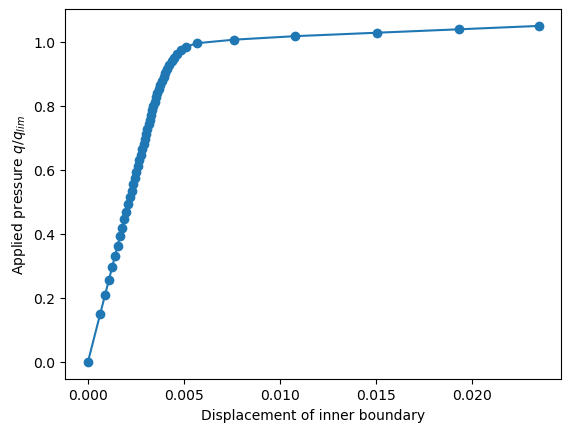

: 

In [13]:
import matplotlib.pyplot as plt
plt.plot(results[:, 0], results[:, 1], "-o")
plt.xlabel("Displacement of inner boundary")
plt.ylabel(r"Applied pressure $q/q_{lim}$")
plt.show()